# Bismayan's recoding of Rossmann POC

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from isoweek import Week
import random,pickle
import numpy as np
import datetime
from pandas_summary import DataFrameSummary
import feather
from functools import partial

%matplotlib inline


## Getting the Main Data Files

In [2]:
data_path="/media/2tb_hdd/deeplearning_data/rossmann_data/"
file_save_path="/media/2tb_hdd/deeplearning_data/rossmann_data/"
#data_path="/mnt/disks/data_disk/rossmann_data/"
#file_save_path="/mnt/disks/data_disk/rossmann_data/bismayan_files/"

# Preprocessing for Entity Embeddings (Restart from here to skip feature engineering)

In [3]:
joined=feather.read_dataframe(f'{file_save_path}/joined.feather')

In [4]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler

This dictionary maps categories to embedding dimensionality. In generally, categories we might expect to be conceptually more complex have larger dimension.

In [5]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

Name categorical variables (sorted in order of embedding size)

In [6]:
cat_vars = [o[0] for o in 
            sorted(cat_var_dict.items(),key=lambda x:x[1], reverse=True)]

Name continuous Variables

In [7]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

Replace nulls w/ 0 for continuous, "" for categorical.

In [8]:
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""

In [9]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

The same instances need to be used for the test set as well, so values are mapped/standardized appropriately.

DataFrame mapper will keep track of these variable-instance mappings.

In [10]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
cat_cols

22

In [11]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
contin_cols

16

We can also pickle these mappings, which is great for portability!

In [12]:
#pickle.dump(contin_map_fit, open(f'{file_save_path}contin_maps.pickle', 'wb'))
#pickle.dump(cat_map_fit, open(f'{file_save_path}cat_maps.pickle', 'wb'))

### Taking Sample (Set sample size to length of df to train on full dataset)

In [67]:
joined_sales = joined[joined.Sales!=0]
#joined_sales=joined
n = len(joined_sales)

In [68]:
samp_size = n
np.random.seed(1234)
idxs = sorted(np.random.choice(n, samp_size, replace=False),reverse=True)
joined_samp = joined_sales.iloc[idxs].set_index("Date")

In time series data, cross-validation is not random. Instead, our holdout data is always the most recent data, as it would be in real application.

Here are preprocessors for our categoricals and continuous variables using our instance mapper.

In [69]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [70]:
cat_map= cat_preproc(joined_samp)
contin_map = contin_preproc(joined_samp)

Grab our targets.

In [71]:
y= joined_samp.Sales

Root-mean-squared percent error is the metric Kaggle used for this competition.

## Create Model Inputs

In [72]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [73]:
map_cols = split_cols(cat_map) + [contin_map]

In [74]:
len(map_cols)

23

Helper function for getting categorical name and dim.

In [75]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)


Note we're flattening the embedding. Embeddings in Keras come out as an element of a sequence like we might use in a sequence of words; here we just want to concatenate them so we flatten the 1-vector sequence into a vector.

In [76]:
def get_emb(feat):
    name, c = cat_map_info(feat)
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    emb=Embedding(c, c2, input_length=1, embeddings_initializer="RandomNormal",name=name+"_embed")(inp)
    u = Flatten(name=name+'_flt')(emb)
    return inp,u

Helper function for continuous inputs.

## Defining RMSPE Keras Loss 

In [77]:
def rmspe_loss(y_true,y_pred):
    import tensorflow.keras.backend as K
    diff = K.square((y_true - y_pred) / K.clip(K.abs(y_true),
                                            1e-1,
                                            None))
    return  K.sqrt(K.mean(diff, axis=-1))

## Modelling

In [78]:
def schedule_lr(epoch,interval=5, multiplier=0.3,base_rate=0.01):
    exp=int((epoch)%interval)
    return base_rate*(multiplier**exp)

def cosine_lr(epoch,base_rate,interval=10):
    import numpy as np
    lr= base_rate*np.cos(int(epoch%interval)*np.pi/(4*interval))
    return lr

In [79]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Embedding,Concatenate,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,TerminateOnNaN,TensorBoard,EarlyStopping,ReduceLROnPlateau
from keras_tqdm import TQDMNotebookCallback
from tensorflow.keras.optimizers import Adam, SGD,RMSprop

In [80]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)
embs = [get_emb(feat) for feat in cat_map_fit.features]
x = Concatenate(axis=-1)([emb for inp,emb in embs] + [contin_out])
x=BatchNormalization()(x)
#x = Dropout(0.1)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.10)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.20)(x)
x = Dense(1, activation=None)(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)
model.compile(SGD(lr=0.01,clipvalue=0.5), loss=rmspe_loss)

In [81]:
checkpoint= ModelCheckpoint("/media/2tb_hdd/deeplearning_data/rossmann_data/saved_model_full",verbose=1)
term= TerminateOnNaN()
tqdm_callback= TQDMNotebookCallback(leave_inner=True,metric_format='{name}: {value:0.5f}')

try:
    model.load_weights(f"{file_save_path}saved_model_backup_0.08630")
    print("Loading model Weights from previous model")
except:
    print("Could not load model Weights from previous model")
hist = model.fit(map_cols, y, batch_size=512, epochs=5,
                 verbose=0,callbacks=[checkpoint,term,tqdm_callback])

Loading model Weights from previous model



Epoch 00001: saving model to /media/2tb_hdd/deeplearning_data/rossmann_data/saved_model_full



Epoch 00002: saving model to /media/2tb_hdd/deeplearning_data/rossmann_data/saved_model_full



Epoch 00003: saving model to /media/2tb_hdd/deeplearning_data/rossmann_data/saved_model_full



Epoch 00004: saving model to /media/2tb_hdd/deeplearning_data/rossmann_data/saved_model_full



Epoch 00005: saving model to /media/2tb_hdd/deeplearning_data/rossmann_data/saved_model_full


## Plotting Predictions 

In [82]:
model.load_weights(f"{file_save_path}saved_model_full")

In [83]:
pred=model.predict(map_cols)

In [84]:
save=joined_samp[["Store","DayOfWeek","Sales","Customers","Open","Promo","StateHoliday","SchoolHoliday"]]


In [85]:
pred

array([[6079.438 ],
       [4597.837 ],
       [5047.158 ],
       ...,
       [8671.206 ],
       [5637.002 ],
       [4891.5195]], dtype=float32)

In [86]:
save["PredictedSales"]=pred

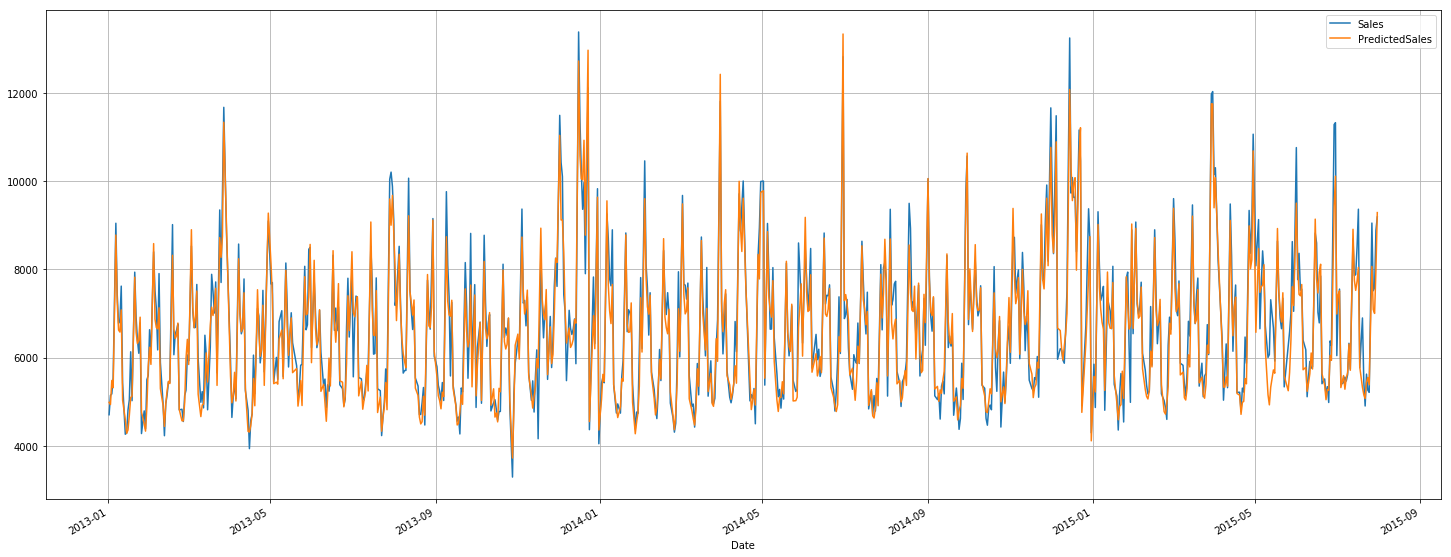

In [87]:
store_num=15
save[save["Store"]==store_num].plot(y=["Sales","PredictedSales"],figsize=(25,10),grid=True)


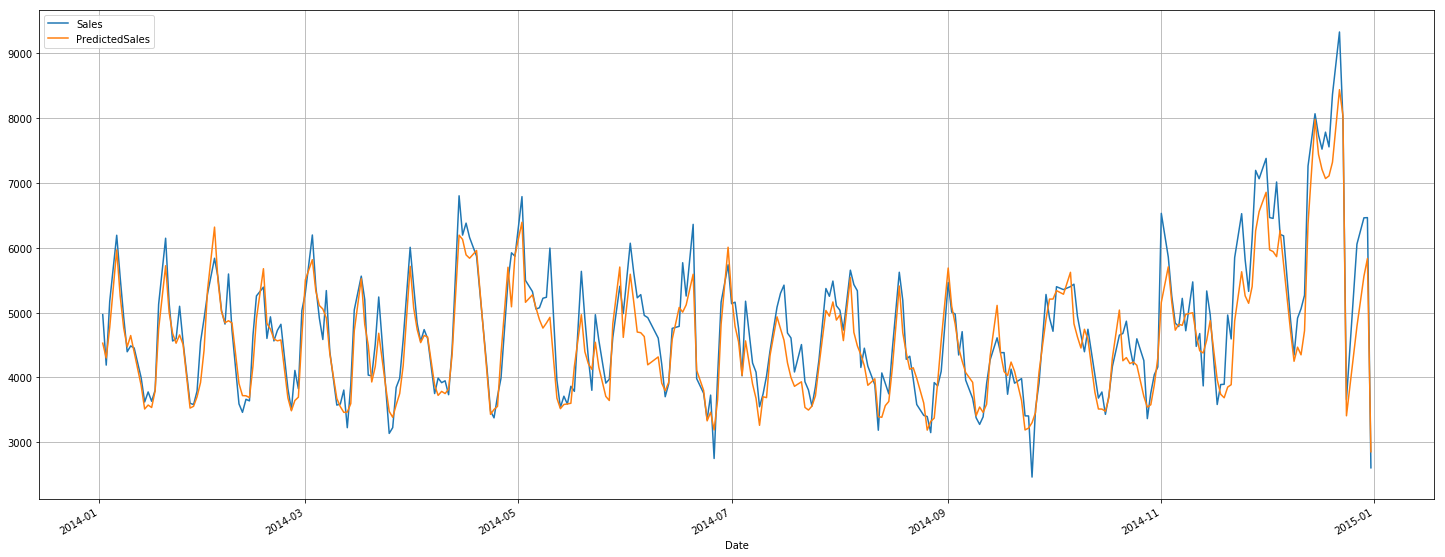

In [100]:
save[(save["Store"])==store_num & (save.index.year==2014)].plot(y=["Sales","PredictedSales"],figsize=(25,10),grid=True)

## Generating Predictions

In [88]:
joined_test=feather.read_dataframe(f'{file_save_path}/joined_test.feather')

In [89]:
for v in contin_vars: joined_test.loc[joined_test[v].isnull(), v] = 0
for v in cat_vars: joined_test.loc[joined_test[v].isnull(), v] = ""

In [90]:
cat_map_test = cat_preproc(joined_test)
contin_map_test = contin_preproc(joined_test)

In [91]:
map_test = split_cols(cat_map_test) + [contin_map_test]

In [92]:
len(map_test)

23

In [93]:
model.load_weights("/media/2tb_hdd/deeplearning_data/rossmann_data/saved_model_full")

In [94]:
test_preds=model.predict(map_test)

In [95]:
preds_submit= pd.DataFrame(joined_test["Id"])
preds_submit["Sales"]=test_preds
preds_submit.head()

,Id,Sales
0,1,4379.496582
1,2,6959.652344
2,3,9101.929688
3,4,6219.961914
4,5,7226.870117


In [96]:
preds_submit.to_csv("submit_full_redone.csv",index=False)

## Displaying embeddings in Tensorboard

In [100]:
import tensorflow as tf
import tensorflow.keras as keras

In [105]:
model.load_weights(f"{file_save_path}saved_model_backup_10487")
saver = tf.train.Saver()
sess = keras.backend.get_session()
save_path = saver.save(sess, "./tboard_logs/model.ckpt")

In [103]:
total_string=""
for i in cat_maps:
    np.savetxt(f"tboard_logs/{i[0]}_metadata.tsv",i[1].classes_,fmt='%s', delimiter="\n")
    write_string=f'''
                 embeddings {{
                             tensor_name: "{i[0]}_embed/embeddings"
                             metadata_path:"{i[0]}_metadata.tsv" 
                }}
                '''
    total_string= total_string+write_string

In [104]:
with open("./tboard_logs/projector_config.pbtxt","w") as f:
    print(total_string,file=f)